# Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# GAN
![image about general adversarial networks (GAN)](./resources/gan.png)

### Create Discriminator
- using the MNIST dataset, a single image is going to be 28x28x1
- a single color channel (grayscale) 28x28 images
<br/> <br/><br/>
![convolutional layer output formula](./resources/convolutional-layer-formula.png)
- formula for calculating the output dimension of the convolution operation

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.kernel_sz = (3, 3)
        self.stride = 1

        self.model = nn.Sequential(
            # 1x28x28
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=self.kernel_sz, stride=self.stride), # 64x26x26
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=self.kernel_sz, stride=self.stride), # 128x24x24
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=self.kernel_sz, stride=self.stride), # 256x22x22
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=self.kernel_sz, stride=self.stride), # 256x20x20
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=256 * 20 * 20, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


Discriminator_test_instance = Discriminator()
Discriminator_test_instance = Discriminator_test_instance.to(device) # ensuring the whole nn is in a single device
summary(model=Discriminator_test_instance, input_size=(1, 28, 28), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
              ReLU-2           [-1, 64, 26, 26]               0
            Conv2d-3          [-1, 128, 24, 24]          73,856
              ReLU-4          [-1, 128, 24, 24]               0
            Conv2d-5          [-1, 256, 22, 22]         295,168
              ReLU-6          [-1, 256, 22, 22]               0
            Conv2d-7          [-1, 256, 20, 20]         590,080
              ReLU-8          [-1, 256, 20, 20]               0
           Flatten-9               [-1, 102400]               0
           Linear-10                    [-1, 1]         102,401
          Sigmoid-11                    [-1, 1]               0
Total params: 1,062,145
Trainable params: 1,062,145
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

### Create Generator
![](./resources/transposed-convolutional-layer-formula.png)
- formula for calculating the output dimension of the transposed convolution operation

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]         316,736
              ReLU-2                 [-1, 3136]               0
         Unflatten-3             [-1, 64, 7, 7]               0
   ConvTranspose2d-4           [-1, 32, 16, 16]          32,800
              ReLU-5           [-1, 32, 16, 16]               0
   ConvTranspose2d-6           [-1, 16, 34, 34]           8,208
              ReLU-7           [-1, 16, 34, 34]               0
            Conv2d-8            [-1, 1, 28, 28]             785
              Tanh-9            [-1, 1, 28, 28]               0
Total params: 358,529
Trainable params: 358,529
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 1.37
Estimated Total Size (MB): 1.86
-------------------------------------------

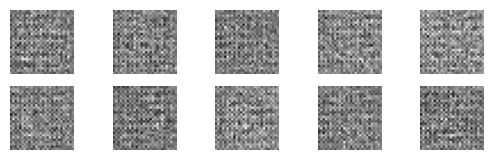

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=7*7*64),  # [n, 256, 7, 7]
            nn.ReLU(),
            # reshape data from 1 dimension to batch of 2 dimensional data
            nn.Unflatten(dim=1, unflattened_size=(64, 7, 7)),
            
            # reduce feature maps to 32, increase image size to 16x16
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2),
            nn.ReLU(),
            # reduce feature maps to 16, increase image size to 28x28
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2), # [n, 16, 34, 34]
            nn.ReLU(),
            
            # reduce feature maps to 1, decrease image size to 28x28 
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=7),  # [n, 1, 28, 28]
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


# assume some hyperparameters for now
latent_dim = 100
batch_size = 64

Generator_test_instance = Generator(latent_dim=latent_dim)
Generator_test_instance = Generator_test_instance.to(device=device)
summary(model=Generator_test_instance, input_size=(latent_dim,), device=device)

noise = torch.randn(batch_size, latent_dim, device=device)
fake_samples = Generator_test_instance(noise)
fake_samples = (fake_samples + 1) / 2.0
fake_samples = fake_samples.to('cpu').detach().numpy()

for i in range(10):
    plt.subplot(5, 5, i+1) # rows, cols, index
    plt.axis('off')
    plt.imshow(fake_samples[i][0], cmap='gray')
plt.show()

### Hyperparameters

In [5]:
input_size = 784  # 28x28 pixels
learning_rate = 0.001
batch_size = 64
num_epochs = 10  # Reduced for demonstration purposes
latent_dim = 100

# MNIST dataset

In [6]:
train_dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="dataset/", download=True, train=False, transform=transforms.ToTensor())

combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
data_loader = DataLoader(dataset=combined_dataset, batch_size=batch_size, shuffle=True)

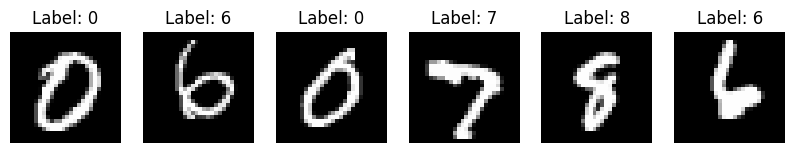

In [7]:
examples = iter(data_loader)
example_data, example_targets = next(examples)


fig, axes = plt.subplots(1, 6, figsize=(10, 3))
for i in range(6):
    axes[i].imshow(example_data[i][0], cmap="gray")
    axes[i].set_title(f"Label: {example_targets[i]}")
    axes[i].axis("off")
plt.show()

In [8]:
print(f"dim of single image = {example_data[0].size()}")

dim of single image = torch.Size([1, 28, 28])


# Training

In [9]:
Discriminator = Discriminator()
Discriminator = Discriminator.to(device)

Generator = Generator(latent_dim=latent_dim)
Generator = Generator.to(device)

criterion = nn.BCELoss()
optimizer_D = optim.Adam(Discriminator.parameters(), lr=learning_rate)
optimizer_G = optim.Adam(Generator.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    
    for batch_index, (X_real, y_real) in enumerate(tqdm(data_loader)):
        # labels for real and fake data
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        # ---------------------------------
        # |      Train Discriminator      |
        # ---------------------------------
        optimizer_D.zero_grad()
        
        # real data for discriminator training
        X_real = X_real.to(device)

        d_scores_real = Discriminator(X_real)
        d_loss_real = criterion(d_scores_real, real_labels)

        # generate fake data for discriminator training
        noise = torch.randn(batch_size, latent_dim, device=device)
        X_fake = Generator(noise)

        d_scores_fake = Discriminator(X_fake)
        d_loss_fake = criterion(d_scores_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # -----------------------------
        # |      Train Generator      |
        # -----------------------------
        optimizer_G.zero_grad()

        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_images = Generator(noise)
        
        # get discriminator predictions
        d_pred = Discriminator(fake_images)
        
        # generator loss
        g_loss = criterion(d_pred, real_labels)
        g_loss.backward()
        optimizer_G.step()

Epoch [1/10]


  0%|          | 0/1094 [00:00<?, ?it/s]

100%|█████████▉| 1093/1094 [09:37<00:00,  1.89it/s]


ValueError: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([48, 1])) is deprecated. Please ensure they have the same size.